In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [8]:
# ==============================================================================
# Global Parameters (Placeholders - Define these based on your specific problem)
# ==============================================================================
# Define constants
X_MIN, X_MAX = 0.0, 1.0  # Spatial domain [0, L]
T_MIN, T_MAX = 0.0, 1.0  # Time domain [0, T]
L = X_MAX - X_MIN
n = 1                    # Mode for initial condition (e.g., sin(n*pi*x/L))

# Function: Exact solution
def u_exact(x, t, alpha):
    return np.exp(-n**2 * np.pi**2 * alpha * t / L**2) * np.sin(n * np.pi * x / L)
 

In [9]:
# ==============================================================================
# 1. MODEL DEFINITION (Class-based Network)
# ==============================================================================

class PINN_Net(nn.Module):
    """
    Standard Multi-Layer Perceptron (MLP) for PINN, replacing the make_net function.
    Uses Tanh activation and Xavier initialization.
    """
    def __init__(self, layers=(2, 128, 128, 128, 1)):
        super(PINN_Net, self).__init__()
        self.activation = nn.Tanh()
        self.fcs = nn.ModuleList() # Use ModuleList to store linear layers

        # Build all layers (input, hidden, and output)
        for i in range(len(layers) - 1):
            self.fcs.append(nn.Linear(layers[i], layers[i+1]))

        # Initialize weights (Xavier Uniform is standard for Tanh)
        for fc in self.fcs:
            if fc.weight.dim() > 1: # Apply only to weight matrices
                nn.init.xavier_uniform_(fc.weight)
        
    def forward(self, x):
        # Pass input through hidden layers with activation
        for i in range(len(self.fcs) - 1):
            x = self.activation(self.fcs[i](x))
        # Final output layer (no activation)
        x = self.fcs[-1](x)
        return x

# ==============================================================================
# 2. SAMPLING AND RESIDUAL FUNCTIONS
# ==============================================================================

def pde_residual(model, x, t, alpha):
    """
    Calculates the residual of the 1D Heat Equation: u_t - alpha * u_xx.
    """
    # Enable gradient tracking for the input coordinates (x and t)
    x.requires_grad_(True)
    t.requires_grad_(True)

    # Forward pass: get the predicted solution u(x, t)
    u = model(torch.cat([x, t], dim=1))
    
    # Calculate derivatives using Autograd
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # Return the PDE residual (f = u_t - alpha * u_xx)
    return u_t - alpha * u_xx


def sample_points(N_f=10000, N_i=200, N_b=200):
    """
    Generates collocation points for the PDE, IC, and BC.
    """
    # 1. Collocation points (interior) - x and t are sampled uniformly
    x_f = torch.FloatTensor(N_f, 1).uniform_(X_MIN, X_MAX).to(device)
    t_f = torch.FloatTensor(N_f, 1).uniform_(T_MIN, T_MAX).to(device)

    # 2. Initial condition (t = T_MIN = 0)
    x_i = torch.linspace(X_MIN, X_MAX, N_i).view(-1, 1).to(device)
    t_i = torch.zeros_like(x_i).to(device)
    u_i = torch.sin(n * np.pi * x_i / L).to(device) # Exact IC value
    
    # 3. Boundary conditions (t is sampled, x is fixed at boundaries)
    t_b = torch.linspace(T_MIN, T_MAX, N_b).view(-1, 1).to(device)
    x_b0 = X_MIN * torch.ones_like(t_b).to(device) # Left boundary (x=0)
    x_b1 = X_MAX * torch.ones_like(t_b).to(device) # Right boundary (x=L)

    # Return points grouped by condition (PDE, IC, BC)
    return (x_f, t_f), (x_i, t_i, u_i), (x_b0, x_b1, t_b)

# ==============================================================================
# 3. LOSS AND TRAINING FUNCTIONS
# ==============================================================================

def pinn_loss(model, alpha, pts):
    """
    Calculates the total PINN loss (L_f + L_i + L_b).
    """
    (x_f, t_f), (x_i, t_i, u_i), (x_b0, x_b1, t_b) = pts

    # 1. PDE Loss (L_f): MSE of the PDE residual
    loss_f = torch.mean(pde_residual(model, x_f, t_f, alpha)**2)
    
    # 2. Initial Condition Loss (L_i): MSE of (Predicted IC - Exact IC)
    loss_i = torch.mean((model(torch.cat([x_i, t_i], dim=1)) - u_i)**2)
    
    # 3. Boundary Condition Loss (L_b): MSE of Predicted BC (assuming u=0)
    loss_b = torch.mean(model(torch.cat([x_b0, t_b], dim=1))**2 +
                        model(torch.cat([x_b1, t_b], dim=1))**2)
                        
    return loss_f + loss_i + loss_b


def train(model, alpha, epochs=5000, lr=1e-3):
    """
    Runs the main training loop using the Adam optimizer.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Sample points once before the loop (Static sampling)
    pts = sample_points() 
    history = []

    for ep in range(1, epochs + 1):
        # 1. Forward Pass: Calculate the total PINN loss
        loss = pinn_loss(model, alpha, pts)
        
        # 2. Optimization Steps
        optimizer.zero_grad() 
        loss.backward()       
        optimizer.step()      
        
        # Logging
        if ep % 500 == 0:
            print(f"[α={alpha:.3f}] Epoch {ep} Loss = {loss.item():.3e}")
        history.append(loss.item())
        
    return history


# ==============================================================================
# 4. Prediction/error calculation function
# ==============================================================================
def calculate_prediction_and_error(model, alpha):
    """
    Evaluates the model's performance by calculating predictions, the true solution, 
    and the Mean Squared Error (MSE).
    
    Returns: u_pred, u_true, X, T, error
    """
    # 1. Prepare Test Grid (100x100 points)
    x_vals = np.linspace(X_MIN, X_MAX, 100)
    t_vals = np.linspace(T_MIN, T_MAX, 100)
    X, T = np.meshgrid(x_vals, t_vals) # Create 2D coordinates
    
    # Convert test coordinates to PyTorch tensors
    x_test = torch.tensor(X.flatten()[:, None], dtype=torch.float32).to(device)
    t_test = torch.tensor(T.flatten()[:, None], dtype=torch.float32).to(device)

    # 2. Model Prediction
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Concatenate x and t, predict u, and reshape to 2D grid (100, 100)
        u_pred = model(torch.cat([x_test, t_test], dim=1)).cpu().numpy().reshape(100, 100)
        
    # 3. Reference Solution
    u_true = u_exact(X, T, alpha)

    # 4. Calculate Error (Mean Squared Error)
    error = np.mean((u_pred - u_true)**2)

    # Return all necessary data for visualization and external tracking
    return u_pred, u_true, X, T, error


# ==============================================================================
# 5. Plotting and evaluation functions
# ==============================================================================
def plot_results(u_pred, u_true, X, T, alpha, error, title="PINN"):
    """
    Visualizes the PINN prediction and the exact solution using contour plots.
    """
    # 1. Initialize Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # 2. Plot 1: PINN Prediction
    cf1 = axs[0].contourf(X, T, u_pred, 100, cmap='plasma')
    axs[0].set_title(f"PINN Prediction (α = {alpha})")
    axs[0].set_xlabel("x"); axs[0].set_ylabel("t")
    fig.colorbar(cf1, ax=axs[0], label='u(x,t)')

    # 3. Plot 2: Exact Solution
    cf2 = axs[1].contourf(X, T, u_true, 100, cmap='plasma')
    axs[1].set_title("Exact Solution")
    axs[1].set_xlabel("x"); axs[1].set_ylabel("t")
    fig.colorbar(cf2, ax=axs[1], label='u(x,t)')

    # 4. Final Layout and Title
    plt.suptitle(f"{title} | MSE = {error:.2e}", fontsize=14)
    plt.tight_layout()
    plt.show()


def evaluate(model, alpha, title="PINN", show=True):
    """
    Drives the evaluation process: calculates results and optionally plots them.
    """
    # Calculate all numerical results
    u_pred, u_true, X, T, error = calculate_prediction_and_error(model, alpha)
    
    # Visualize the results if 'show' is True
    if show:
        plot_results(u_pred, u_true, X, T, alpha, error, title)
        
    return error




--- Training Base Model (α = 0.4) ---
[α=0.400] Epoch 500 Loss = 2.000e-03
[α=0.400] Epoch 1000 Loss = 2.167e-04
[α=0.400] Epoch 1500 Loss = 1.106e-04
[α=0.400] Epoch 2000 Loss = 1.785e-02
[α=0.400] Epoch 2500 Loss = 5.854e-05
[α=0.400] Epoch 3000 Loss = 4.837e-05
[α=0.400] Epoch 3500 Loss = 7.390e-05
[α=0.400] Epoch 4000 Loss = 4.159e-05
[α=0.400] Epoch 4500 Loss = 8.622e-05
[α=0.400] Epoch 5000 Loss = 6.895e-03


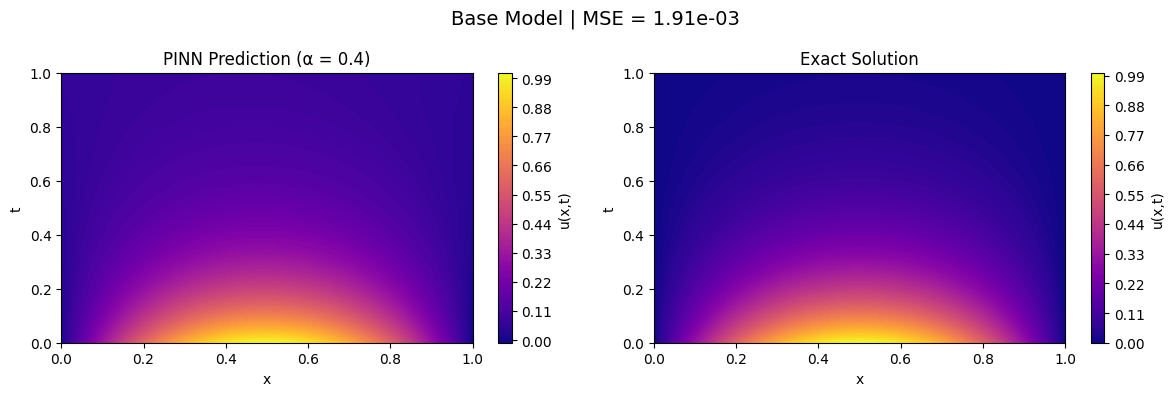


--- Starting Transfer Learning ---
Fine-tuning for α = 0.5
[α=0.500] Epoch 500 Loss = 1.337e-04
[α=0.500] Epoch 1000 Loss = 7.694e-05
[α=0.500] Epoch 1500 Loss = 5.873e-05
Fine-tuning for α = 0.6
[α=0.600] Epoch 500 Loss = 6.253e-04
[α=0.600] Epoch 1000 Loss = 2.498e-04
[α=0.600] Epoch 1500 Loss = 1.456e-04
Fine-tuning for α = 0.3
[α=0.300] Epoch 500 Loss = 7.428e-05
[α=0.300] Epoch 1000 Loss = 1.421e-05
[α=0.300] Epoch 1500 Loss = 1.005e-05
Fine-tuning for α = 0.01
[α=0.010] Epoch 500 Loss = 3.192e-04
[α=0.010] Epoch 1000 Loss = 9.058e-05
[α=0.010] Epoch 1500 Loss = 5.085e-05


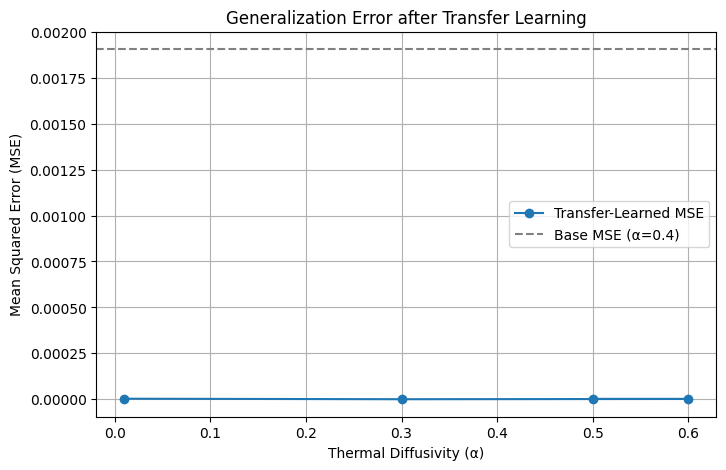

In [12]:

# ==============================================================================
# 6. EXECUTION AND TRANSFER LEARNING
# ==============================================================================

# --- A. Base Model Training ---
alpha_base = 0.4
# Initialize the base network using the PINN_Net class
net_base = PINN_Net().to(device) 
print(f"--- Training Base Model (α = {alpha_base}) ---")
history_base = train(net_base, alpha=alpha_base, epochs=5000, lr=1e-3)
err_base = evaluate(net_base, alpha_base, "Base Model")



# --- B. Transfer Learning and Fine-tuning ---
alphas_new = [0.5, 0.6, 0.3, 0.01]
mse_transfer = []

print("\n--- Starting Transfer Learning ---")
for alpha_new in alphas_new:
    # 1. Initialize New Network
    net_new = PINN_Net().to(device)
    
    # 2. TRANSFER WEIGHTS: Copy weights from the base model (net_base)
    # This initializes the new model close to the solution of the base problem (α=0.4).
    net_new.load_state_dict(net_base.state_dict()) 
    
    # 3. Fine-tuning: Train the transferred model on the new, related problem (alpha_new)
    # Uses fewer epochs and a lower learning rate for fine-tuning stability.
    print(f"Fine-tuning for α = {alpha_new}")
    # Note: Using net_new (transferred weights)
    train(net_new, alpha=alpha_new, epochs=1500, lr=2e-4)
    
    # 4. Evaluate and Store Error
    mse = evaluate(net_new, alpha_new, title=f"Fine-tuned α={alpha_new}", show=False)
    mse_transfer.append(mse)


# --- C. Results Visualization ---
plt.figure(figsize=(8, 5))
# Plot the MSE results obtained via transfer learning for different alphas
plt.plot(alphas_new, mse_transfer, "o-", label="Transfer-Learned MSE") 

# Plot a horizontal line showing the base model's error (for comparison)
plt.axhline(err_base, ls="--", color='gray', label=f"Base MSE (α={alpha_base})")

plt.xlabel("Thermal Diffusivity (α)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Generalization Error after Transfer Learning")
plt.legend(); plt.grid(True); plt.show()